## PCA Homework

by:
- Tommaso Mazzarini (s332078)
- Riccardo Pisanu (s328202)

### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import display
#%matplotlib widget

### 0 - Setting the random state

In [2]:
random_state = min(332078,328202)

In [3]:
random.seed(random_state)

## 1 - Loading and Preparing the Data

### 1.1 - Import the dataset

In [4]:
# Import csv
file_name = 'cla4lsp_customers.csv'
df_tot = pd.read_csv(file_name, sep='\t')

### 1.2 - Split dataset

We are going to split the dataset in two sets and we will use only the first one (*workdf*) containing 2/3 of the original data.

In [5]:
# Split the dataset
workdf, not_workdf = train_test_split(df_tot, test_size = 1/3, shuffle=True, random_state=random_state)

In [6]:
# Save the dataframes
workdf.to_csv('working_dataset.csv')
not_workdf.to_csv('not_working_dataset.csv')

In [7]:
# Import the datasets
workdf = pd.read_csv('working_dataset.csv')
not_workdf = pd.read_csv('not_working_dataset.csv')

### 1.3 - Divide columns 

First of all, we divide the columns based on their purpose.

We have features (*'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'*)

and labels (*'NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain', 'Recency'*)

and some other columns that are useless for this analysis, which will just be dropped.

In [8]:
labels = ['NumDealsPurchases','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3',
          'AcceptedCmp4','AcceptedCmp5','Response','Complain','Recency']

features = ['Year_Birth','Education','Marital_Status','Income','Kidhome',
            'Teenhome','Dt_Customer','MntWines','MntFruits','MntMeatProducts',
            'MntFishProducts','MntSweetProducts','MntGoldProds','NumWebPurchases',
            'NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']

other_columns = [col for col in workdf.columns if col not in (labels + features)]

In [9]:
# Drop unknown columns
workdf = workdf.drop(other_columns, axis=1)

### 1.4 - Remove a random feature

Let's remove a random feature. Using the random seed set at the begininning of the analysis, *'NumStorePurchases'* is the dropped column.

In [10]:
purchasing_habits = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

In [11]:
# Removing random feature
random_pick = random.choice(purchasing_habits)
workdf = workdf.drop(random_pick, axis=1)
features.remove(random_pick)

In [12]:
random_pick

'NumStorePurchases'

### 1.5 - Data cleaning

Before beginning the encoding of the features, we had to clean the dataset from missing values.

Luckly, we observed that only 16 values were missing, all in the feature *'Income'*. Since it is a small number compared to the total of data, we just removed all the 16 clients with missing value for *'Income'*.

In [13]:
print(f' NaN elements from working set:\n{workdf[features].isna().sum()}')
print(f' \nNaN elements from NON working set:\n{not_workdf[features].isna().sum()}')

 NaN elements from working set:
Year_Birth              0
Education               0
Marital_Status          0
Income                 16
Kidhome                 0
Teenhome                0
Dt_Customer             0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumWebPurchases         0
NumCatalogPurchases     0
NumWebVisitsMonth       0
dtype: int64
 
NaN elements from NON working set:
Year_Birth             0
Education              0
Marital_Status         0
Income                 8
Kidhome                0
Teenhome               0
Dt_Customer            0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumWebPurchases        0
NumCatalogPurchases    0
NumWebVisitsMonth      0
dtype: int64


In [14]:
# Drop NaN values
workdf.dropna(inplace=True)
not_workdf.dropna(inplace=True)

## 2 - Encoding of Categorical Data

Some features have categorical data, so, in order to work with those, we need to convert them. The features are:

1) *MaritalStatus*:
To encode *'MaritalStatus'*, we used the 'One-Hot Encoding' method, which assign  a new binary variable to each category (*'Married', 'Single', 'Together', 'Divorced', 'Absurd', 'Alone', 'YOLO', 'Widow'*), so we obtain 8 new features with only values 0 or 1 instead of the original feature. We decided to use this method because we did not need any order between categories and, even if the dimensionality of the problem increases, it is the most valuable way to encode that.

2)*'Education'*:
since there are different levels of education and that can definitely be useful for the analysis. So we decide to use another method of encoding, the 'Label Encoding', which ranks each category based on the level of education as it follows:

1) *Basic*
2) *2n Cycle*
3) *Graduation*
4) *Master*
5) *PhD*



In [15]:
# Encode the Marital_Status feature with one hot encoding 
workdf = pd.get_dummies(workdf, columns=['Marital_Status'])

workdf = workdf.replace({True: 1, False: 0})

In [16]:
# Encode the Education feature with one hot encoding 

dict = {'Graduation':3, 
        'PhD':5, 
        'Master':4, 
        '2n Cycle':2, 
        'Basic':1
}

workdf['Education_level'] = workdf['Education'].map(dict)
workdf = workdf.drop(columns=['Education'])

Now we, are going to encode the feature *'Dt_Customer*. First, we convert it from a string to datetime. Then, we find the enrollment date of the last customer and we calculate how many days of enrollment all the other costumers  have with respect to this last date.

In [17]:
# Dt_Customer encoded as days of subscription with respect to the last customer subscription

workdf['Dt_Customer'] = pd.to_datetime(workdf['Dt_Customer'],format = '%d-%m-%Y')

last_customer = workdf['Dt_Customer'].max()

list_days = []
for date in workdf['Dt_Customer']:
    days = last_customer - date
    list_days.append(days.days)

workdf['Customer_For'] = list_days
workdf = workdf.drop(columns='Dt_Customer') 

In [18]:
# Update features list
features = [feature for feature in workdf.columns if feature not in labels]

In [19]:
# Define sub-df by selecting feature columns
Xworkdf = workdf[features]

## 3 - Preprocessing and full-PCA

### 3.1 - Standardize the features

By observing the dataframe, we notice that features have many differences about scales and range of values. These differences could wrongly influence the PCA, excluding some features just for the dimensionality, so it is necessary to rescale the data.

We used two scale techniques:
1) **Standard Scaler**: it is the most used data preprocessing method, it standardizes the data re-centering them and normalizing the standard deviation. It is a very useful technique even if, since it redistribute the variance among all the features, it could give more importance to less important features.

2) **Min-Max Scaler**: it distributes the value of each column between a minimum value $m$ and a maximum value $M$. It is useful for data with "rank value", and in this case we will use $m=0$ and $M=1$.

In [20]:
# Create Xworkdf_std using the Standard scaler
Xworkdf_std = StandardScaler()
#fit
Xworkdf_std.fit(Xworkdf.values)
#transform
t_Xworkdf_std = Xworkdf_std.transform(Xworkdf.values)

# Create Xworkdf_mm using the MinMax scaler
Xworkdf_mm = MinMaxScaler()
#fit
Xworkdf_mm.fit(Xworkdf.values)
#transform
t_Xworkdf_mm = Xworkdf_mm.transform(Xworkdf.values)

### 3.2 - First look at the variances

By looking at the description of data, as expected, we see many differences between variances.
The original dataframe *Xworkdf* has very different ranges and dimensions of variance, and that is the reason why we had to rescale it.
The dataframe *Xworkdf_std*, by definition, has variance=1, since it divides the variance between all the features (also the less relevant).
The dataframe *Xworkdf_mm* has very small variances, different from each other, but also this is reasonable, since all the scaled values are between 0 and 1.

In [21]:
Xworkdf.describe().loc['std'] ** 2

Year_Birth                 1.480499e+02
Income                     7.106744e+08
Kidhome                    2.939600e-01
Teenhome                   2.934792e-01
MntWines                   1.109045e+05
MntFruits                  1.553905e+03
MntMeatProducts            5.168922e+04
MntFishProducts            3.033955e+03
MntSweetProducts           1.722545e+03
MntGoldProds               2.470898e+03
NumWebPurchases            7.093122e+00
NumCatalogPurchases        8.770520e+00
NumWebVisitsMonth          5.792212e+00
Marital_Status_Absurd      1.353179e-03
Marital_Status_Alone       2.028392e-03
Marital_Status_Divorced    8.750342e-02
Marital_Status_Married     2.366778e-01
Marital_Status_Single      1.686749e-01
Marital_Status_Together    1.944587e-01
Marital_Status_Widow       3.524778e-02
Marital_Status_YOLO        6.770481e-04
Education_level            9.901452e-01
Customer_For               4.176125e+04
Name: std, dtype: float64

In [22]:
pd.DataFrame(t_Xworkdf_std, columns=Xworkdf.columns).describe().loc['std'] ** 2

Year_Birth                 1.000678
Income                     1.000678
Kidhome                    1.000678
Teenhome                   1.000678
MntWines                   1.000678
MntFruits                  1.000678
MntMeatProducts            1.000678
MntFishProducts            1.000678
MntSweetProducts           1.000678
MntGoldProds               1.000678
NumWebPurchases            1.000678
NumCatalogPurchases        1.000678
NumWebVisitsMonth          1.000678
Marital_Status_Absurd      1.000678
Marital_Status_Alone       1.000678
Marital_Status_Divorced    1.000678
Marital_Status_Married     1.000678
Marital_Status_Single      1.000678
Marital_Status_Together    1.000678
Marital_Status_Widow       1.000678
Marital_Status_YOLO        1.000678
Education_level            1.000678
Customer_For               1.000678
Name: std, dtype: float64

In [23]:
pd.DataFrame(t_Xworkdf_mm, columns=Xworkdf.columns).describe().loc['std'] ** 2

Year_Birth                 0.013955
Income                     0.001607
Kidhome                    0.073490
Teenhome                   0.073370
MntWines                   0.049821
MntFruits                  0.039239
MntMeatProducts            0.017391
MntFishProducts            0.045580
MntSweetProducts           0.025094
MntGoldProds               0.039853
NumWebPurchases            0.009730
NumCatalogPurchases        0.011187
NumWebVisitsMonth          0.014481
Marital_Status_Absurd      0.001353
Marital_Status_Alone       0.002028
Marital_Status_Divorced    0.087503
Marital_Status_Married     0.236678
Marital_Status_Single      0.168675
Marital_Status_Together    0.194459
Marital_Status_Widow       0.035248
Marital_Status_YOLO        0.000677
Education_level            0.061884
Customer_For               0.085471
Name: std, dtype: float64

### 3.3 - Full PCA

Let's apply PCA. The goals of this type of analysis are:

- reducing the number of features, still preserving most of the dataset's information;
- observing correlation between features and get new information.

Summarizing, we compute the eigenvalues $\lambda$ and the corresponding orthogonal eigenvectors $V$ from the covariance matrix. Then the problem needs to be analyzed with respect to the orthogonal basis $V$, where the direction of the axes correspond to the ones of greater variance.

So, the greater is $\lambda_i$ (the $i$-th greater eigenvalue of the covariance matrix), the greater is the variance of the data with respect to the direction of $v_i$ (the $i$-th principal component of the matrix of data), for each $i=1,...,n$.

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


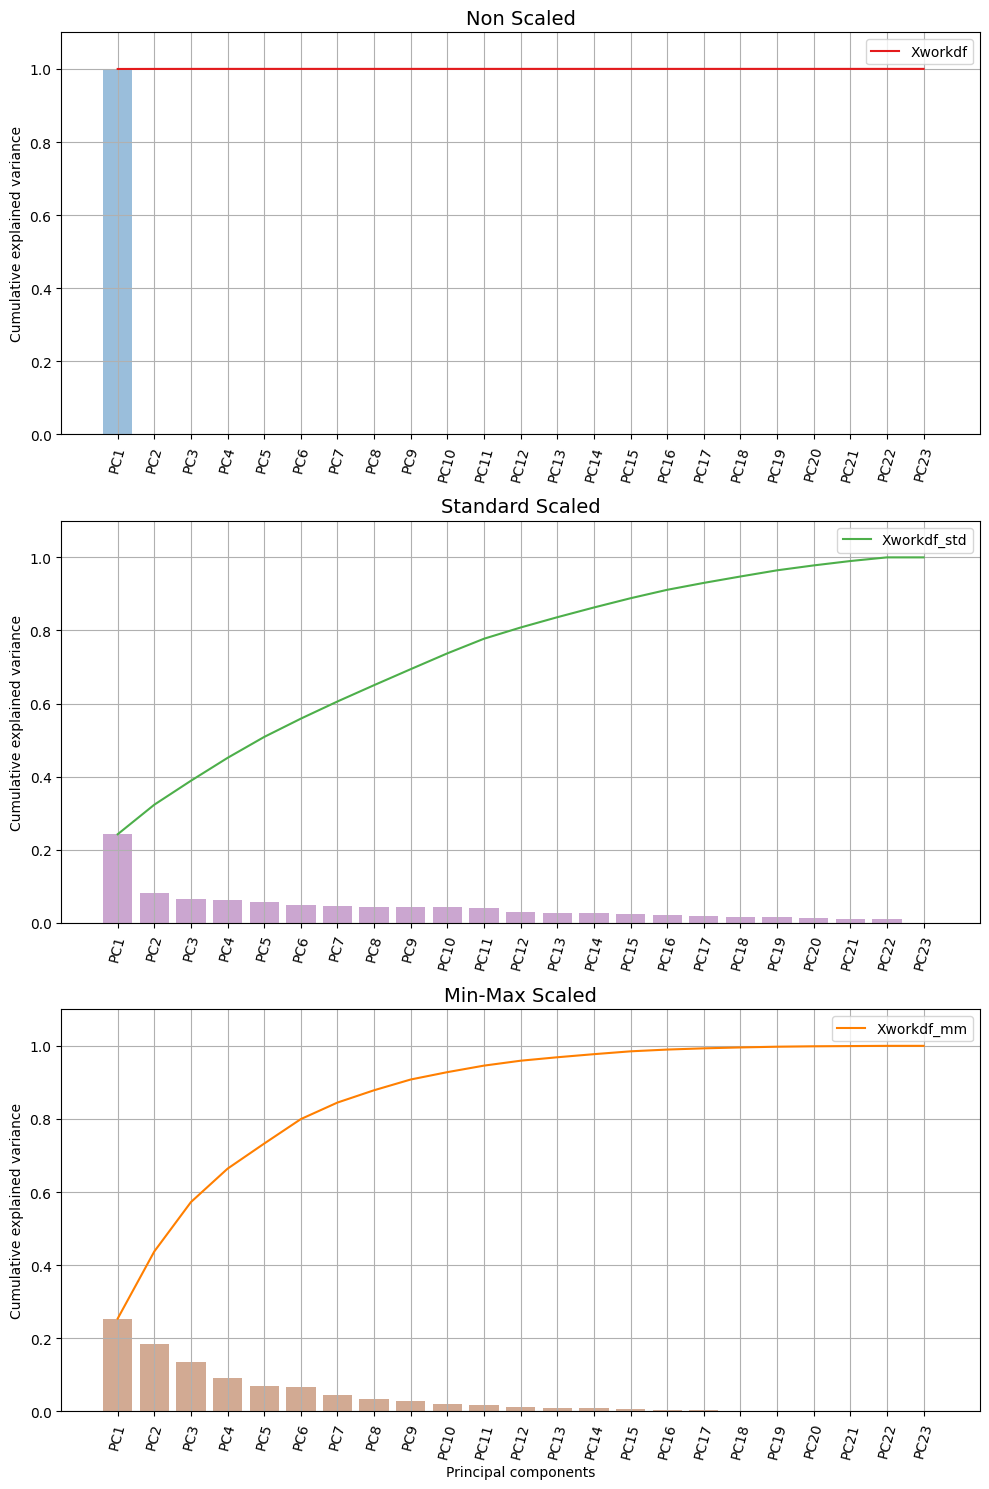

In [24]:
#Apply the “full” PCA1 to the DFs Xworkdf, Xworkdf_std, and Xworkdf_mm
pca_Xworkdf = PCA()
pca_Xworkdf_std = PCA()
pca_Xworkdf_mm = PCA()

pca_Xworkdf.fit(Xworkdf[features].values) 
pca_Xworkdf_std.fit(t_Xworkdf_std)
pca_Xworkdf_mm.fit(t_Xworkdf_mm)


# color set
set1 = cm.Set1.colors

# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharey=True)

# Plot for non-scaled data
axes[0].plot(np.cumsum(pca_Xworkdf.explained_variance_ratio_), c=set1[0], label='Xworkdf')
axes[0].bar(height=pca_Xworkdf.explained_variance_ratio_, x=np.arange(23), color=set1[1], alpha=0.5)
axes[0].set_title('Non Scaled', fontsize=14)

# Plot for standard scaled data
axes[1].plot(np.cumsum(pca_Xworkdf_std.explained_variance_ratio_), c=set1[2], label='Xworkdf_std')
axes[1].bar(height=pca_Xworkdf_std.explained_variance_ratio_, x=np.arange(23), color=set1[3], alpha=0.5)
axes[1].set_title('Standard Scaled', fontsize=14)

# Plot for min-max scaled data
axes[2].plot(np.cumsum(pca_Xworkdf_mm.explained_variance_ratio_), c=set1[4], label='Xworkdf_mm')
axes[2].bar(height=pca_Xworkdf_mm.explained_variance_ratio_, x=np.arange(23), color=set1[6], alpha=0.5)
axes[2].set_title('Min-Max Scaled', fontsize=14)

# Customize the common properties of subplots
for ax in axes:
    ax.set_ylim([0, 1.1])
    ax.set_xticks(np.arange(pca_Xworkdf.n_features_))
    ax.set_xticklabels([f'PC{i + 1}' for i in range(pca_Xworkdf.n_features_)], rotation=75)
    ax.set_ylabel('Cumulative explained variance')
    ax.legend()
    ax.grid()
    
# Set common y-label and legend
axes[2].set_xlabel('Principal components')
axes[0].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

By looking at the previous graph, as expected the non scaled data have only one PC that dominates the other explains the whole variance.

Scaled data seem more reasonable, with some differences: observing the same number of PC of the two different scales, Min-Max scaled data explain more variance, and that's because of the influence of the binary features.


## 4 - Dimensionality Reduction and Interpretation of the PCs

### 4.1 - Selection and display of PCs

We have to select $m$ PCs such that $m=min(m',5)$, where $m'$ is the minimum number of PCs that explains 33% of variance.

In both cases of rescale we obtain 2 as the minimum number of PCs that explains 33% of variance.

More precisely, with standard scaled data we explain 33.78% of total variance, while with min-max scaled data we explain the 46.87%.

In [25]:
m_star_std = 2 # m' of Xworkdf_std
m_star_mm = 2 # m' of Xworkdf_mm

m_std = min(m_star_std,5)
m_mm = min(m_star_mm,5)

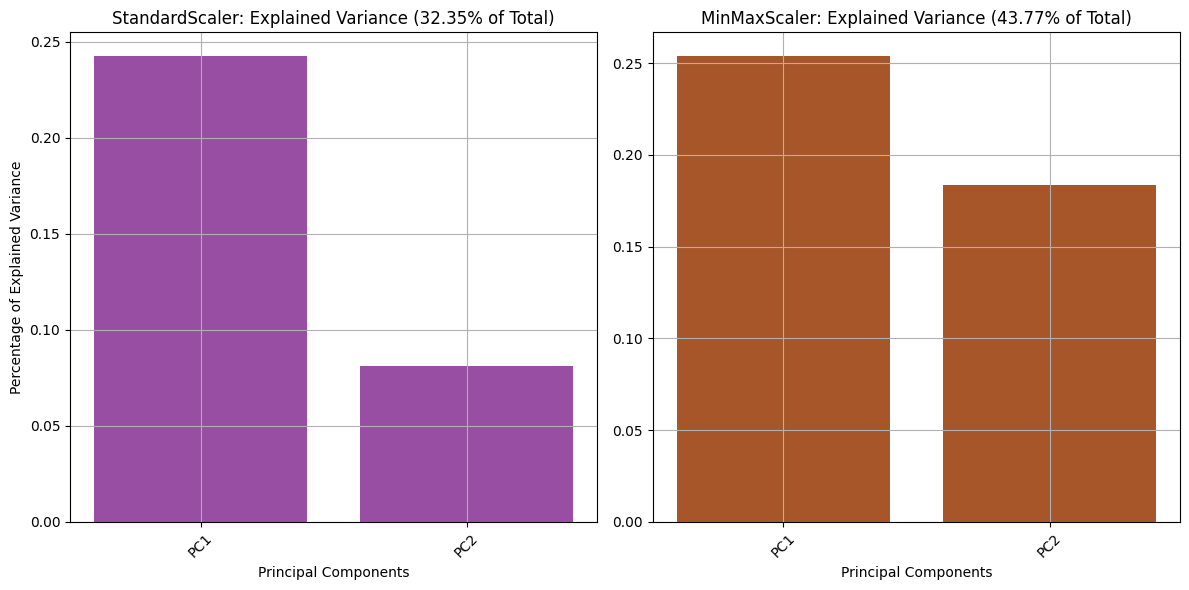

In [26]:
# Perform PCA
pca_std = PCA(n_components=m_std)
pca_mm = PCA(n_components=m_mm)

pca_std.fit(t_Xworkdf_std)
pca_mm.fit(t_Xworkdf_mm)

# Explained variance rounded to 2 decimals
round_expl_var_ratio_std = np.round(pca_std.explained_variance_ratio_.sum() * 100, 2)
round_expl_var_ratio_mm = np.round(pca_mm.explained_variance_ratio_.sum() * 100, 2)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for StandardScaler data
axes[0].bar(range(1, m_std + 1), pca_std.explained_variance_ratio_, color=set1[3])
axes[0].set_title(f"StandardScaler: Explained Variance ({round_expl_var_ratio_std}% of Total)")
axes[0].set_xticks(np.arange(1, m_std + 1))
axes[0].set_xticklabels([f'PC{i}' for i in range(1, m_std + 1)], rotation=45)
axes[0].set_xlabel('Principal Components')
axes[0].set_ylabel('Percentage of Explained Variance')
axes[0].grid()

# Plot for MinMaxScaler data
axes[1].bar(range(1, m_mm + 1), pca_mm.explained_variance_ratio_, color=set1[6])
axes[1].set_title(f"MinMaxScaler: Explained Variance ({round_expl_var_ratio_mm}% of Total)")
axes[1].set_xticks(np.arange(1, m_mm + 1))
axes[1].set_xticklabels([f'PC{i}' for i in range(1, m_mm + 1)], rotation=45)
axes[1].set_xlabel('Principal Components')
axes[1].grid()

plt.tight_layout()
plt.show()

### 4.2 - Interpretation of the PCs

We consider relevant for the analysis only the contribute of the features over a prefixed threshold $\epsilon = \sqrt{1/n}$, where $n$
 is the number of features.

First we divide the features into three categories in order to get a nice visualization:

1) 'Personal info': characteristics related to customer information;
2) 'Amounts': amount spent by the customer on different products;
3) 'Place': places where purchases have been made.

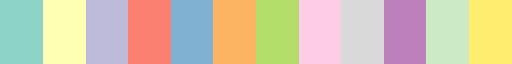

,feature,category,color
0,Year_Birth,Personal_info,"(0.5529411764705883, 0.8274509803921568, 0.780..."
1,Income,Personal_info,"(0.5529411764705883, 0.8274509803921568, 0.780..."
2,Kidhome,Personal_info,"(0.5529411764705883, 0.8274509803921568, 0.780..."
3,Teenhome,Personal_info,"(0.5529411764705883, 0.8274509803921568, 0.780..."
4,MntWines,Amounts,"(1.0, 1.0, 0.7019607843137254)"
5,MntFruits,Amounts,"(1.0, 1.0, 0.7019607843137254)"
6,MntMeatProducts,Amounts,"(1.0, 1.0, 0.7019607843137254)"
7,MntFishProducts,Amounts,"(1.0, 1.0, 0.7019607843137254)"
8,MntSweetProducts,Amounts,"(1.0, 1.0, 0.7019607843137254)"
9,MntGoldProds,Amounts,"(1.0, 1.0, 0.7019607843137254)"


In [27]:
# Set the color for different categories of features

# dataframe with these columns [features, category, color]
set3 = cm.Set3.colors

display(cm.Set3)

# Define the feature-category mapping
cat_dict = {
    'Year_Birth': 'Personal_info', 
    'Income': 'Personal_info', 
    'Kidhome': 'Personal_info', 
    'Teenhome': 'Personal_info', 
    'MntWines': 'Amounts', 
    'MntFruits': 'Amounts',
    'MntMeatProducts': 'Amounts', 
    'MntFishProducts': 'Amounts', 
    'MntSweetProducts': 'Amounts',
    'MntGoldProds': 'Amounts', 
    'NumWebPurchases': 'Place', 
    'NumCatalogPurchases': 'Place',
    'NumStorePurchases':'Place',
    'NumWebVisitsMonth': 'Place', 
    'Education_level': 'Personal_info',
    'Marital_Status_Absurd': 'Personal_info',
    'Marital_Status_Alone': 'Personal_info',
    'Marital_Status_Divorced': 'Personal_info', 
    'Marital_Status_Married': 'Personal_info',
    'Marital_Status_Single': 'Personal_info', 
    'Marital_Status_Together': 'Personal_info',
    'Marital_Status_Widow': 'Personal_info', 
    'Marital_Status_YOLO': 'Personal_info',
    'Customer_For': 'Personal_info'
}

# Create a DataFrame with features and their categories
feature_cat_df = pd.DataFrame({'feature': Xworkdf.columns})
feature_cat_df['category'] = feature_cat_df['feature'].map(cat_dict)

# Define colors for different categories
cat_colors = {
    'Personal_info': cm.Set3.colors[0],
    'Amounts': cm.Set3.colors[1],
    'Place': cm.Set3.colors[2],
}

# Assign colors to categories
feature_cat_df['color'] = feature_cat_df['category'].map(cat_colors)

# Display the DataFrame with features, categories, and assigned colors
display(feature_cat_df)

#### 4.2.1 - Interpretation of the PCs for StandardScaler data

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


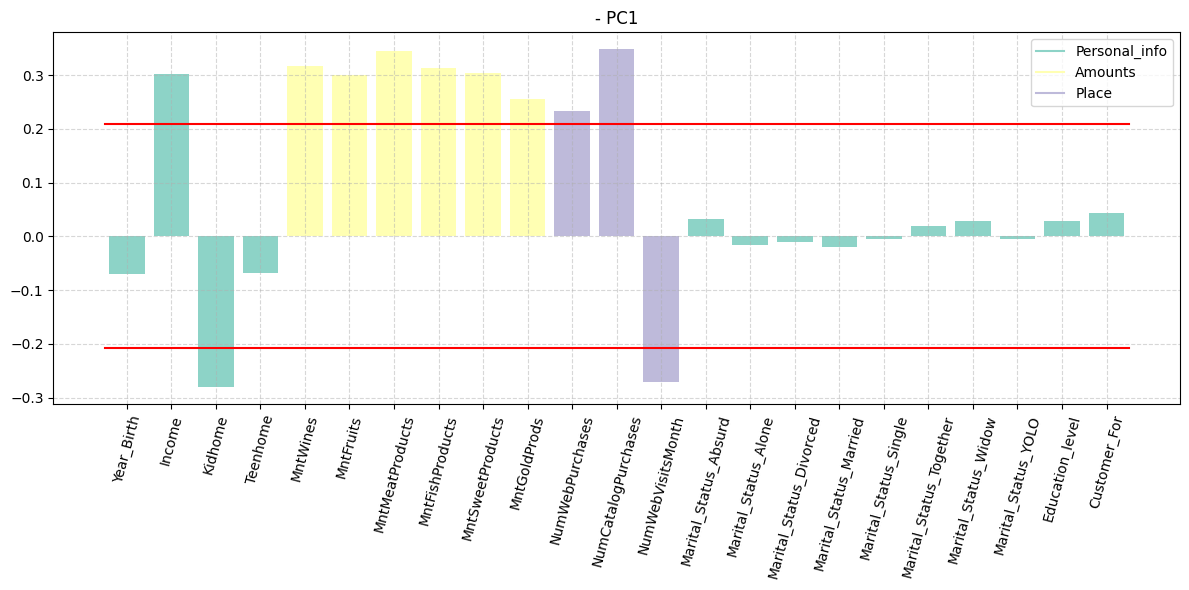

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)



****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases']

HIGH-VALUED NEGATIVE COMPONENTS: ['Kidhome', 'NumWebVisitsMonth']
*********************************************



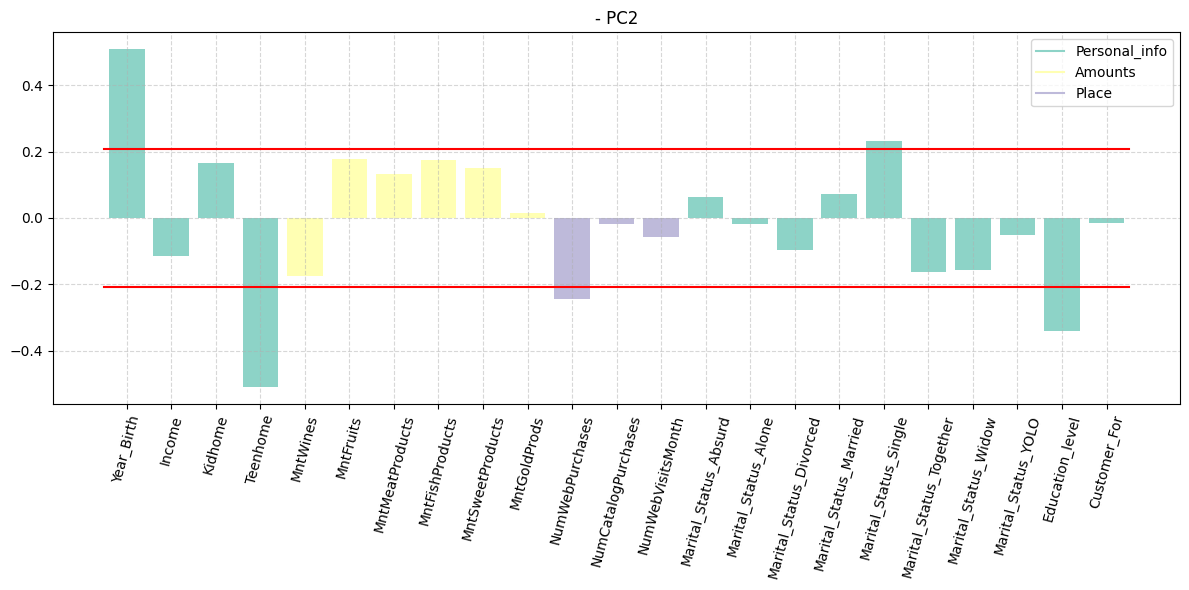


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Year_Birth', 'Marital_Status_Single']

HIGH-VALUED NEGATIVE COMPONENTS: ['Teenhome', 'NumWebPurchases', 'Education_level']
*********************************************



In [28]:
# Epsilon for treshold
eps = np.sqrt(1 / pca_std.n_features_)

# List of category color
cat_color = [feature_cat_df.loc[feature_cat_df['category'] == s]['color'].values[0] for s in feature_cat_df['category']]

# Legend
cat_colors_legend = [Line2D([0], [0], color=cat_colors[k]) for k in cat_colors.keys()]

# One plot for each PC
for ii in range(m_std):
    
    # Barplots with color with respect to different categories
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(pca_std.n_features_), pca_std.components_[ii, :], color= cat_color)
    
    # Treshold lines
    plt.plot([-0.5, pca_std.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_std.n_features_ - 0.5], [-eps, -eps], 'red')
   
    plt.xticks(ticks=np.arange(pca_std.n_features_),
               labels= features,
               rotation=75)
    plt.title(f'- PC{ii + 1}')
    plt.legend(cat_colors_legend, [k for k in cat_colors.keys()])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    # The selection of features whose value is greater than the threshold 
    ind_great_pos_PCii = np.argwhere(pca_std.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_std.components_[ii, :] <= -eps).flatten()
    
    great_pos_PCii = [features[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [features[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')

By looking at the first two principal components:

1) the first has **high positive** values for the features 'Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', whose represent a client with high power of purchase, and it has **high negative** values for the features 'Kidhome', 'NumWebVisitsMonth'.

2) the second component has **high positive** values for the features 'Year_Birth', 'Marital_Status_Single', whose can represent a young client, and **high negative** values for 'Education', 'Teenhome', 'NumWebPurchases', whose can represent a client with a family and a high education.

PCs' name:
1) **PC1**: 'Purchase power'
2) **PC2**: 'Family & High education (-) VS Young Customer(+)'

In [29]:
pc_names_std = ['PP',
                'FE (-) VS YC(+)'
               ]

#### 4.2.1 - Interpretation of the PCs for MinMaxScaler data

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


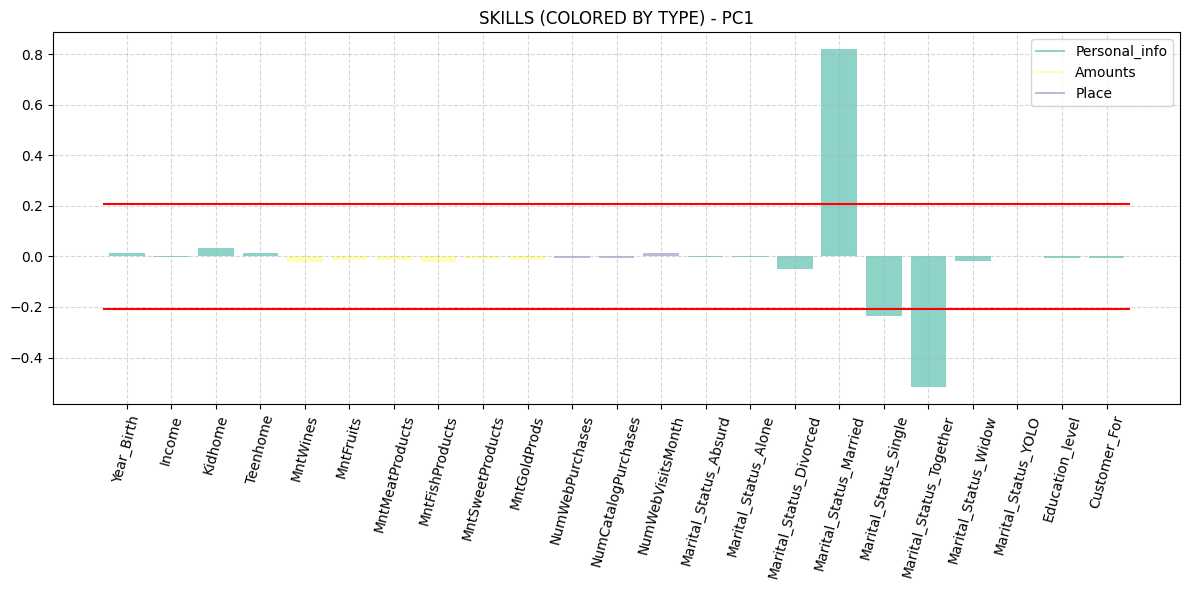

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)



****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Marital_Status_Married']

HIGH-VALUED NEGATIVE COMPONENTS: ['Marital_Status_Single', 'Marital_Status_Together']
*********************************************



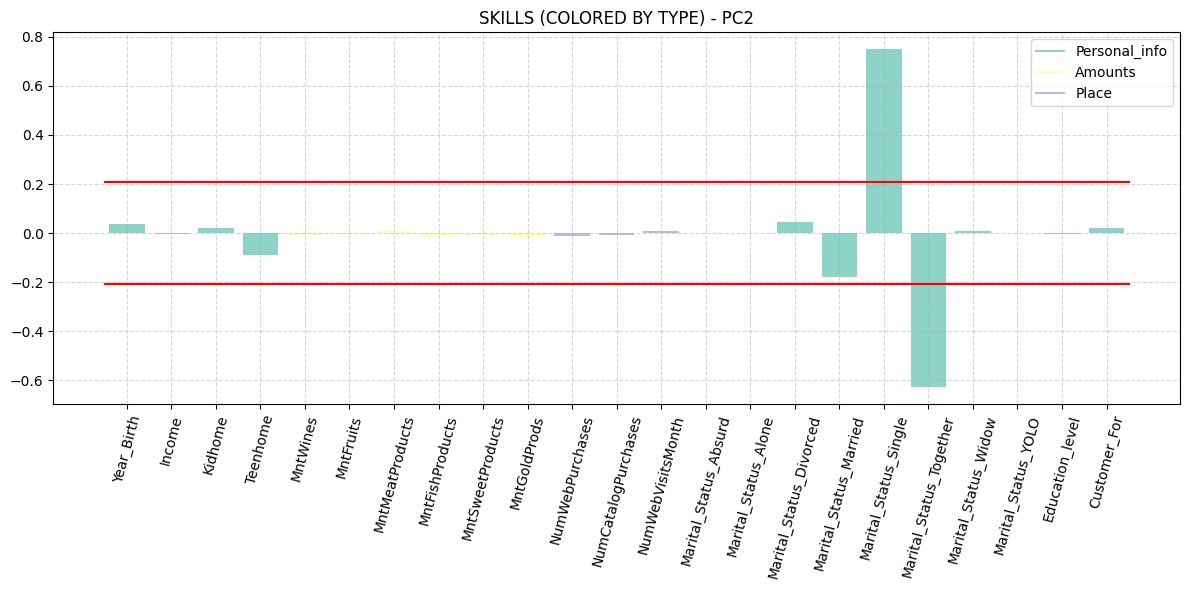


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Marital_Status_Single']

HIGH-VALUED NEGATIVE COMPONENTS: ['Marital_Status_Together']
*********************************************



In [30]:
# Epsilon for treshold
eps = np.sqrt(1 / pca_mm.n_features_)

# List of category color
cat_color = [feature_cat_df.loc[feature_cat_df['category'] == s]['color'].values[0] for s in feature_cat_df['category']]

# Legend
cat_colors_legend = [Line2D([0], [0], color=cat_colors[k]) for k in cat_colors.keys()]

# One plot for each PC
for ii in range(m_mm):
    
    # Barplots with color with respect to different categories
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(pca_mm.n_features_), pca_mm.components_[ii, :], color=cat_color)
    
    # Treshold lines
    plt.plot([-0.5, pca_mm.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_mm.n_features_ - 0.5], [-eps, -eps], 'red')

    plt.xticks(ticks=np.arange(pca_mm.n_features_),
               labels= features,
               rotation=75)
    plt.title(f'SKILLS (COLORED BY TYPE) - PC{ii + 1}')
    plt.legend(cat_colors_legend, [k for k in cat_colors.keys()])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    # THE SELECTION OF THE SKILLS WITH CONTRIBUTE GREATER THAN THE THRESHOLD
    ind_great_pos_PCii = np.argwhere(pca_mm.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_mm.components_[ii, :] <= -eps).flatten()
    
    great_pos_PCii = [features[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [features[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')

By looking at the first two principal components:
1) The first component has **high positive** value only for the feature 'Marital_Status_Married', so it definitely refers to a married client, and it has **high negative** values for 'Marital_Status_Single', 'Marital_Status_Together', so the exact opposite of the positive value.
2) The second component has **high positive** value for the feature 'Marital_Status_Single', representing a single client, and **high negative** value for the feature Marital_Status_Together, so also in this case we have two opposite status.

PCs' name:
1) **PC1**: 'Together & Single (-) VS Married (+)'
2) **PC2**: 'Together (-) VS Single (+)'

In [31]:
pc_names_mm = ['TS (-) VS M (+)',
               'T (-) VS S (+)']

### 4.3 - Score graphs

Looking back at the *'Label'* dataframe, we have decided to focus on the labels: 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', and 'Response', so we colored a customer as 'red' if they made a purchase during any of the first 5 campaigns or the last one (if he bought any product during any campaign). Customers who did not make a purchase during these campaigns will be colored as 'blue'.

To implement this, we will concatenate the columns 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', and 'Response'. If the sum of purchases in any of these campaigns is greater than 0, we will label them as 'red'; otherwise, we will label them as 'blue'.

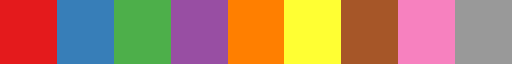

,Campaigns_Accepted,color
0,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."
1,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."
2,True,"(0.8941176470588236, 0.10196078431372549, 0.10..."
3,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."
4,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."
...,...,...
1488,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."
1489,True,"(0.8941176470588236, 0.10196078431372549, 0.10..."
1490,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."
1491,False,"(0.21568627450980393, 0.49411764705882355, 0.7..."


In [32]:
# Set the color for label
set1 = cm.Set1.colors

display(cm.Set1)

# Create a DataFrame with the label and color information
workdf["Campaigns_Accepted"] = workdf[['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response']].sum(axis=1)
workdf = workdf.drop(columns=['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response'])

label_df = pd.DataFrame(workdf["Campaigns_Accepted"])
label_df['Campaigns_Accepted'] = label_df['Campaigns_Accepted'] != 0

# Assign colors based on the label
label_df['color'] = label_df['Campaigns_Accepted'].map({True: set1[0], False: set1[1]})

label_df


#### 4.3.1 - Score graph for StandardScaler data

In [33]:
# PCA transform
Yworkdf_std = pca_std.transform(t_Xworkdf_std)

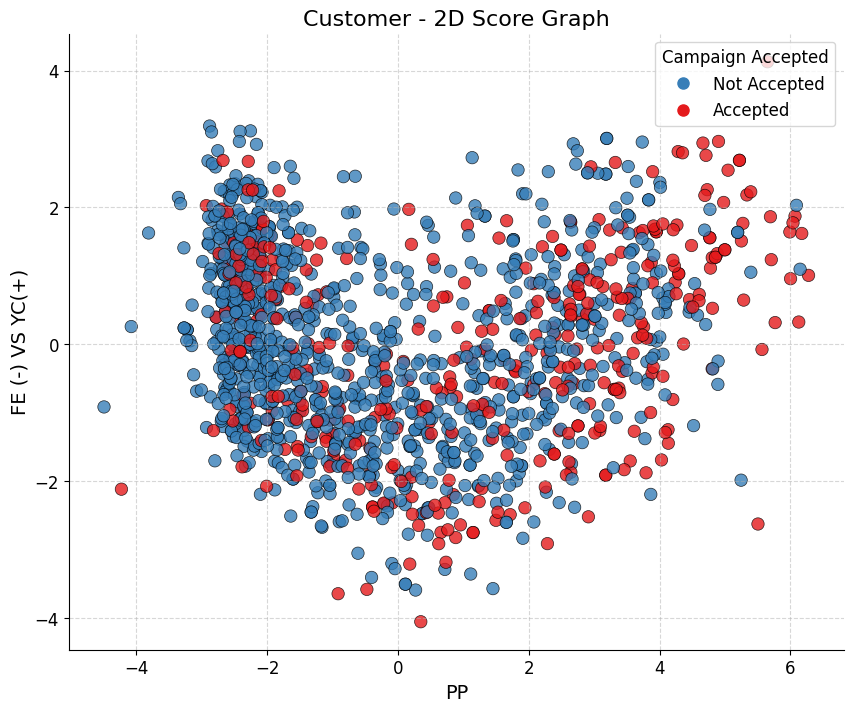

In [34]:
# Create a figure and subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot for 2D scores
scatter = ax.scatter(Yworkdf_std[:, 0], Yworkdf_std[:, 1], c=label_df['color'].values, alpha=0.8, s=80, edgecolors='k', linewidths=0.5)

# Create handles for each label
handles = [plt.Line2D([], [], marker="o", markersize=8, linestyle="", color=color) for color in label_df['color'].unique()]

# Add legend with proper formatting
legend = ax.legend(handles, ['Not Accepted', 'Accepted'], loc='upper right', title='Campaign Accepted', fontsize=12)
legend.set_title(title='Campaign Accepted', prop={'size': '12'})

# Set labels and title with larger fonts
ax.set_xlabel(pc_names_std[0], fontsize=14)
ax.set_ylabel(pc_names_std[1], fontsize=14)
ax.set_title('Customer - 2D Score Graph', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Results with standard scaled data are not very clear, but we can notice some reasonable aspects. There are more 'red' customers on the right, which represents a larger purchase power, so a larger amount of deals. Also, on the left, less purchase power and less campaigns accepted, especially for young customers (higher).

#### 4.3.2 - Score graph for MinMaxScaler data

In [35]:
# PCA transform
Yworkdf_mm = pca_mm.transform(t_Xworkdf_mm)

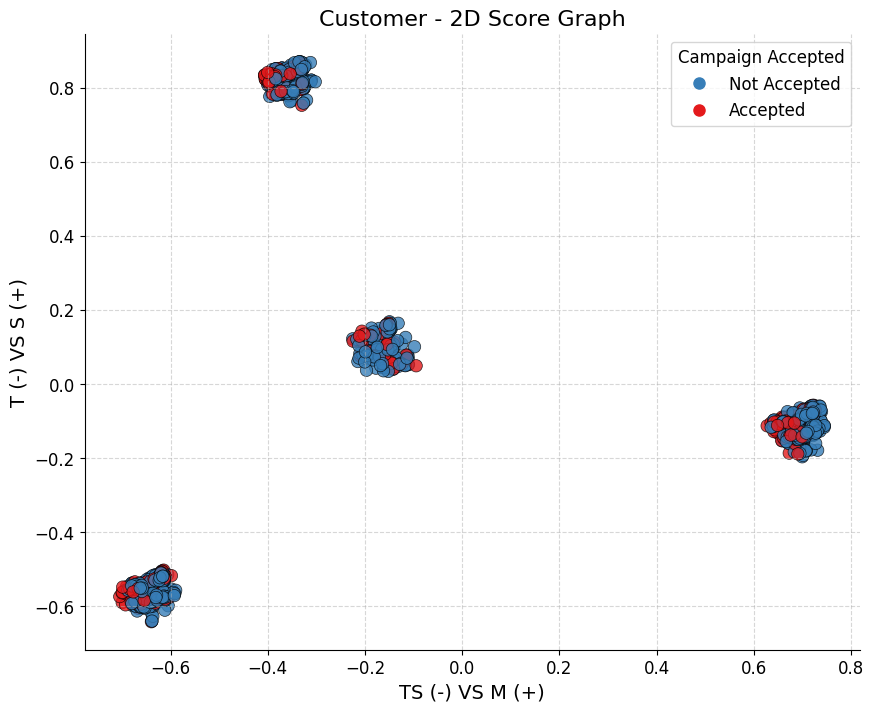

In [36]:
# Create a figure and subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot for 2D scores
scatter = ax.scatter(Yworkdf_mm[:, 0], Yworkdf_mm[:, 1], s=80, c=label_df['color'].values, alpha=0.8, edgecolors='k', linewidths=0.5)

# Create handles for each label
handles = [plt.Line2D([], [], marker="o", markersize=8, linestyle="", color=color) for color in label_df['color'].unique()]

# Add legend with proper formatting
legend = ax.legend(handles, ['Not Accepted', 'Accepted'], loc='upper right', title='Campaign Accepted', fontsize=12)
legend.set_title(title='Campaign Accepted', prop={'size': '12'})

# Set labels and title with larger fonts
ax.set_xlabel(pc_names_mm[0], fontsize=14)
ax.set_ylabel(pc_names_mm[1], fontsize=14)
ax.set_title('Customer - 2D Score Graph', fontsize=16)

# Add grid lines with lighter color
ax.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

With this scale, we clearly see 4 group of points: on the low-right side, we see married-together clients, on the low-left the clients who are together but not married, in the top left the clients who are single and in the center the (only) less clear group of clients. Groups are so clear because of the influence of binary features, and another prove of this is that both the first two PC are only referred to the marital status, so this scale does not seem really meaningful also because we can't see any difference on the labels, it's not clear at all how customers that have accepted campaigns are destributed in the space. 

## 5 - K-Means

Let's apply the *K-Means* algorithm to the dataset. This algorithm computes clusters based on the similarity between objects using Euclidean distance. It can be useful to identify an useful structure of the data.

To select the optimal number $k$ for the k-means, we use the best silhouette coefficient.

To compute it, we calculate k-means for all the given k values, then we compute the silhouette coefficient: $k^* = argmax\frac{1}{N} \sum_{x \in S}s(x)$

For the **standard scaled** data we find $k=3$ as the best coefficient, while for **min-max scaled** we find $k=4$

In [37]:
# Initialize lists to store results
km_list_std = []
silcoeff_list_std = []
k_list_std = list(range(3, 11))

# Iterate over each value of k
for k in k_list_std:
    print(f'Running k-Means with k={k}...')
    
    # Initialize and fit KMeans model
    km = KMeans(n_clusters=k, n_init=3, random_state=random_state)
    km.fit(Yworkdf_std)
    
    # Compute silhouette score
    silhouette_coefficient = silhouette_score(Yworkdf_std, km.labels_)
    
    # Append results to lists
    km_list_std.append(km)
    silcoeff_list_std.append(silhouette_coefficient)

# Find the best value of k and the corresponding KMeans object
best_k_index = np.argmax(silcoeff_list_std)
best_k_std = k_list_std[best_k_index]
best_km_std = km_list_std[best_k_index]

# Visualize the best value of k and its silhouette score
print(f'Best silhouette score: {np.max(silcoeff_list_std)} (k={best_k_std})')

Running k-Means with k=3...
Running k-Means with k=4...
Running k-Means with k=5...
Running k-Means with k=6...
Running k-Means with k=7...
Running k-Means with k=8...
Running k-Means with k=9...
Running k-Means with k=10...
Best silhouette score: 0.45816560073455587 (k=3)


In [38]:
# Initialize lists to store results
km_list_mm = []
silcoeff_list_mm = []
k_list_mm = list(range(3, 11))

# Iterate over each value of k
for k in k_list_mm:
    print(f'Running k-Means with k={k}...')
    
    # Initialize and fit KMeans model
    km = KMeans(n_clusters=k, n_init=3, random_state=random_state)
    km.fit(Yworkdf_mm)
    
    # Compute silhouette score
    silhouette_coefficient = silhouette_score(Yworkdf_mm, km.labels_)
    
    # Append results to lists
    km_list_mm.append(km)
    silcoeff_list_mm.append(silhouette_coefficient)

# Find the best value of k and the corresponding KMeans object
best_k_index = np.argmax(silcoeff_list_mm)
best_k_mm = k_list_mm[best_k_index]
best_km_mm = km_list_mm[best_k_index]

# Visualize the best value of k and its silhouette score
print(f'Best silhouette score: {np.max(silcoeff_list_mm)} (k={best_k_mm})')

Running k-Means with k=3...
Running k-Means with k=4...
Running k-Means with k=5...
Running k-Means with k=6...
Running k-Means with k=7...
Running k-Means with k=8...
Running k-Means with k=9...
Running k-Means with k=10...
Best silhouette score: 0.9403700514302157 (k=4)


## 6 - Clusters and Centroid Interpretation and Visualization

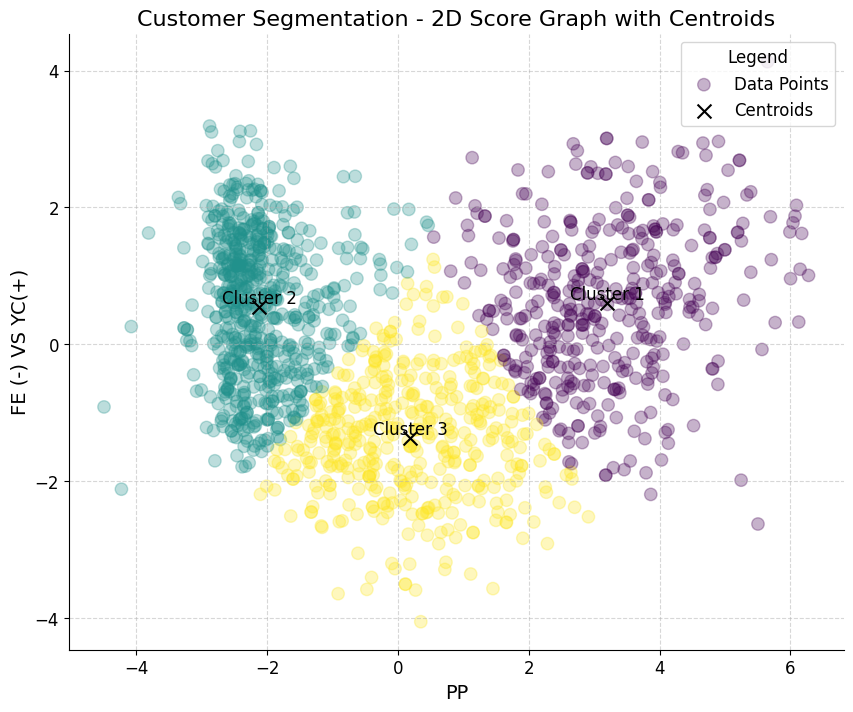

In [39]:
# Create a figure and subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot for 2D scores with cluster centroids
scatter = ax.scatter(Yworkdf_std[:, 0], Yworkdf_std[:, 1], s=80, c=best_km_std.labels_, alpha=0.3, cmap='viridis', label='Data Points')
centroid_scatter = ax.scatter(best_km_std.cluster_centers_[:, 0], best_km_std.cluster_centers_[:, 1], c='black', marker='x', label='Centroids', s=100)

# Set centroid labels
for kk, centroid in enumerate(best_km_std.cluster_centers_):
    ax.text(centroid[0], centroid[1], f'Cluster {kk+1}', ha='center', va='bottom', fontsize=12, color='black')

# Set labels and title with larger fonts
ax.set_xlabel(pc_names_std[0], fontsize=14)
ax.set_ylabel(pc_names_std[1], fontsize=14)
ax.set_title('Customer Segmentation - 2D Score Graph with Centroids', fontsize=16)

# Add legend
legend = ax.legend(loc='upper right', fontsize=12)
legend.set_title(title='Legend', prop={'size': '12'})

# Add grid lines with lighter color
ax.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.show()


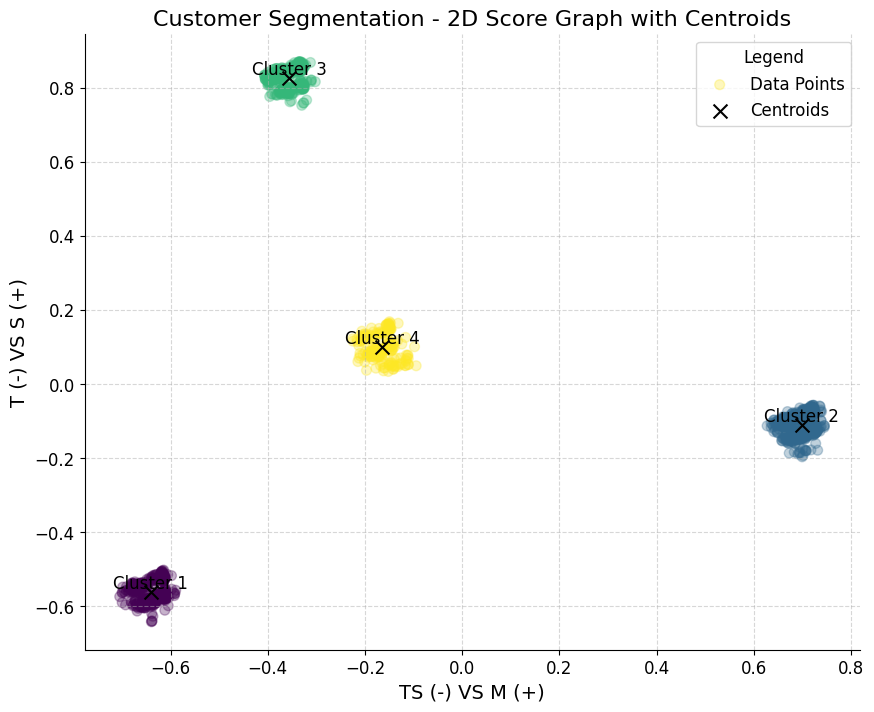

In [40]:
# Create a figure and subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot for 2D scores with cluster centroids
scatter = ax.scatter(Yworkdf_mm[:, 0], Yworkdf_mm[:, 1], s=50, c=best_km_mm.labels_, alpha=0.3, cmap='viridis', label='Data Points')
centroid_scatter = ax.scatter(best_km_mm.cluster_centers_[:, 0], best_km_mm.cluster_centers_[:, 1], c='black', marker='x', label='Centroids', s=100)

# Set centroid labels
for kk, centroid in enumerate(best_km_mm.cluster_centers_):
    ax.text(centroid[0], centroid[1], f'Cluster {kk+1}', ha='center', va='bottom', fontsize=12, color='black')

# Set labels and title with larger fonts
ax.set_xlabel(pc_names_mm[0], fontsize=14)
ax.set_ylabel(pc_names_mm[1], fontsize=14)
ax.set_title('Customer Segmentation - 2D Score Graph with Centroids', fontsize=16)

# Add legend
legend = ax.legend(loc='upper right', fontsize=12)
legend.set_title(title='Legend', prop={'size': '12'})

# Add grid lines with lighter color
ax.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.show()


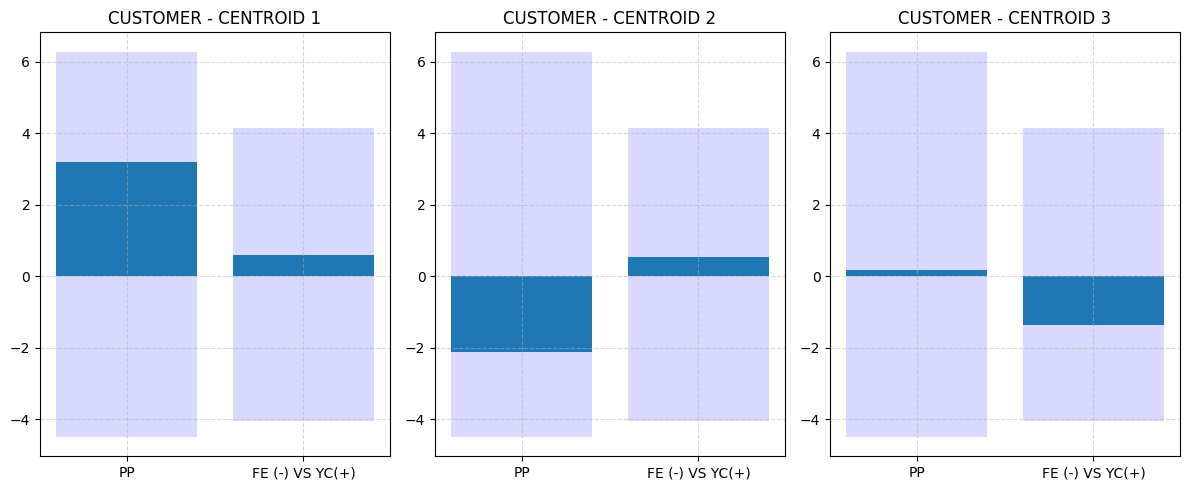

In [41]:
maxs_y = Yworkdf_std.max(axis=0) 
mins_y = Yworkdf_std.min(axis=0) 

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(1,3, figsize=(12, 5))

ax_centroids = ax_centroids.flatten()

for ii in range(best_k_std):
    ax_centroids[ii].bar(np.arange(best_km_std.cluster_centers_.shape[1]), maxs_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(best_km_std.cluster_centers_.shape[1]), mins_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(best_km_std.cluster_centers_.shape[1]), best_km_std.cluster_centers_[ii,:])
    ax_centroids[ii].set_xticks(ticks=np.arange(best_km_std.cluster_centers_.shape[1]))
    ax_centroids[ii].set_xticklabels(labels=pc_names_std)
    ax_centroids[ii].grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    ax_centroids[ii].set_title(f'CUSTOMER - CENTROID {ii+1}')

#### Interpretation of the Centroids
Looking at the PC values of the centroids in the barplots above, we clearly understand that:

- Centroid 1: customers with a family 
- Centroid 2: customers with low purchase power and less purchases
- Centroid 3: customers with high purchase power and many purchases

In [42]:
cluster_names_std = ['Family Oriented',
                     'Moderate Spenders',
                     'Affluent Spenders'
                     ]

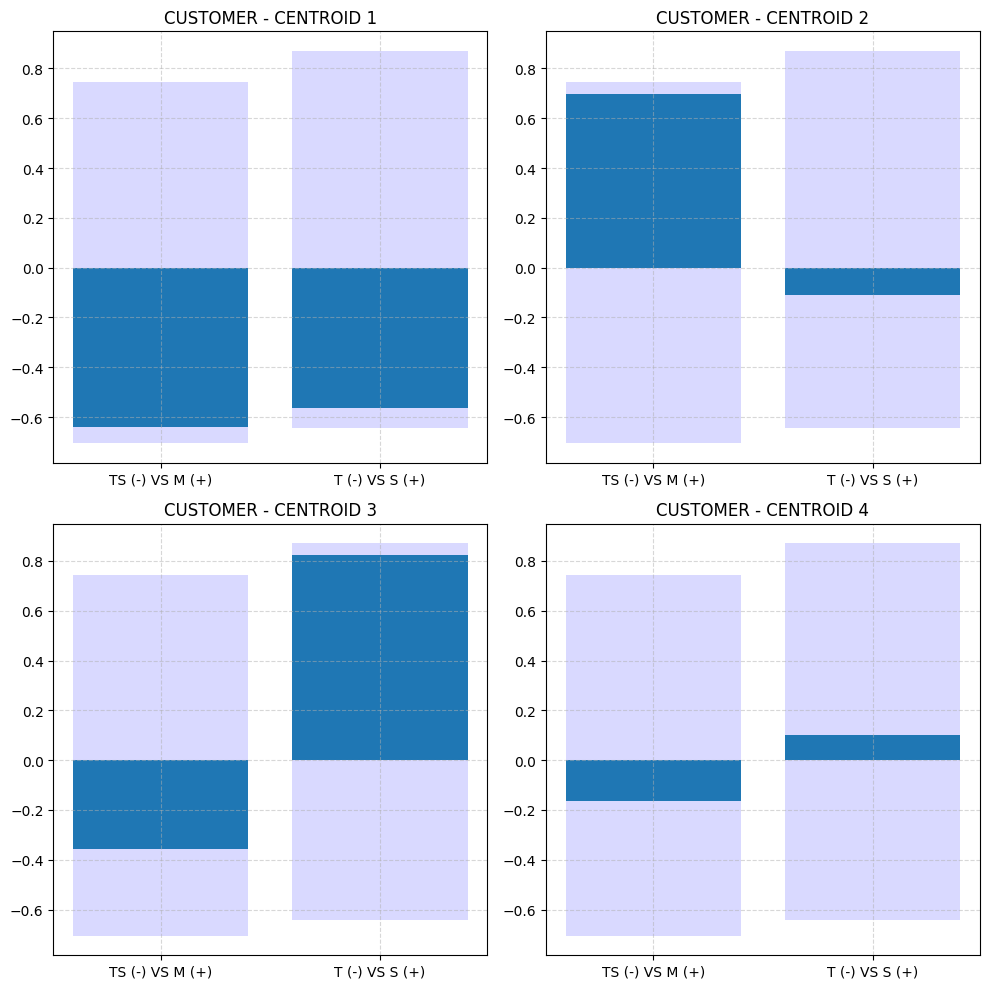

In [43]:
maxs_y = Yworkdf_mm.max(axis=0) 
mins_y = Yworkdf_mm.min(axis=0) 

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(2,2, figsize=(10, 10))

ax_centroids = ax_centroids.flatten()

for ii in range(best_k_mm):
    ax_centroids[ii].bar(np.arange(best_km_mm.cluster_centers_.shape[1]), maxs_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(best_km_mm.cluster_centers_.shape[1]), mins_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(best_km_mm.cluster_centers_.shape[1]), best_km_mm.cluster_centers_[ii,:])
    ax_centroids[ii].set_xticks(ticks=np.arange(best_km_mm.cluster_centers_.shape[1]))
    ax_centroids[ii].set_xticklabels(labels=pc_names_mm)
    ax_centroids[ii].grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    ax_centroids[ii].set_title(f'CUSTOMER - CENTROID {ii+1}')

#### Interpretation of the Centroids
Looking at the PC values of the centroids in the barplots above, we clearly understand that:

- Centroid 1: customers in couple but not married
- Centroid 2: married customers
- Centroid 3: single customers
- Centroid 4: other customers

In [44]:
cluster_names_mm = ['In couple',
                    'Family',
                    'Single',
                    'Other'
                    ]

## 7 - Clusters and Centroid Evaluation

### 7.1 - Internal Evaluation

In [45]:
silscores = silhouette_samples(Yworkdf_std, best_km_std.labels_)
cluster_silscores = [np.mean (silscores [best_km_std.labels_ == kk]) for kk in range (best_k_std) ]
display(pd.DataFrame(np.array(cluster_silscores + [np.max(silcoeff_list_std)]), index=cluster_names_std + ['Global'], columns=['Sil. Score' ]))

,Sil. Score
Family Oriented,0.451042
Moderate Spenders,0.515720
Affluent Spenders,0.379129
Global,0.458166


The silhouette scores for standard scaled data are not very large, but, since they measure the mean intra-cluster distance and the mean nearest-cluster distance for each sample, that is reasonable and noticeable just by looking at the graphs, where all the points are really close and not well distincted.

In [46]:
silscores = silhouette_samples(Yworkdf_mm, best_km_mm.labels_)
cluster_silscores = [np.mean (silscores [best_km_mm.labels_ == kk]) for kk in range (best_k_mm) ]
display(pd.DataFrame(np.array(cluster_silscores + [np.max(silcoeff_list_mm)]), index=cluster_names_mm + ['Global'], columns=['Sil. Score' ]))

,Sil. Score
In couple,0.942286
Family,0.945524
Single,0.937328
Other,0.927044
Global,0.940370


In this case, silhouette score is really large, and we could see it also from the graph, with 4 well distincted groups. 

### 7.1 - External Evaluation

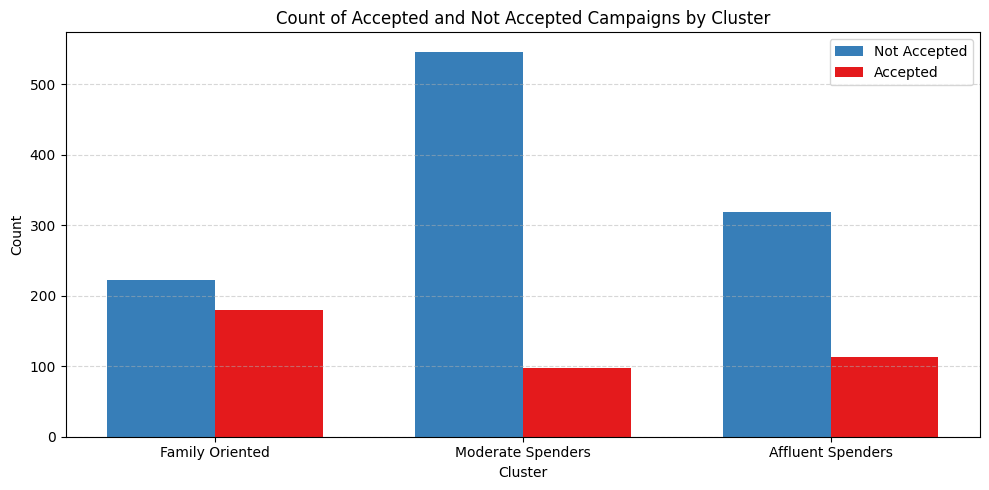

In [47]:
# Calculate the count of accepted and not accepted campaigns for each cluster
accepted_counts = []
not_accepted_counts = []

for cluster in range(best_k_std):
    accepted_counts.append(np.sum(best_km_std.labels_ == cluster) - np.sum(label_df.loc[best_km_std.labels_ == cluster, 'Campaigns_Accepted']))
    not_accepted_counts.append(np.sum(label_df.loc[best_km_std.labels_ == cluster, 'Campaigns_Accepted']))

# Create bar chart with side-by-side bars
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = np.arange(best_k_std)

bar1 = plt.bar(index - bar_width/2, accepted_counts, bar_width, label='Not Accepted', color=set1[1])
bar2 = plt.bar(index + bar_width/2, not_accepted_counts, bar_width, label='Accepted', color=set1[0])

plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Count of Accepted and Not Accepted Campaigns by Cluster')
plt.xticks(index, cluster_names_std)
plt.legend()

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Although the number of campaigns not accepted is higher than those accepted, we can see that the clusters are well representative. For example, if we focus our attention on the Affluent Spenders cluster, we can see that it has almost twice as many accepted campaigns as the Moderate Spenders cluster, while the third cluster is in an intermediate position.

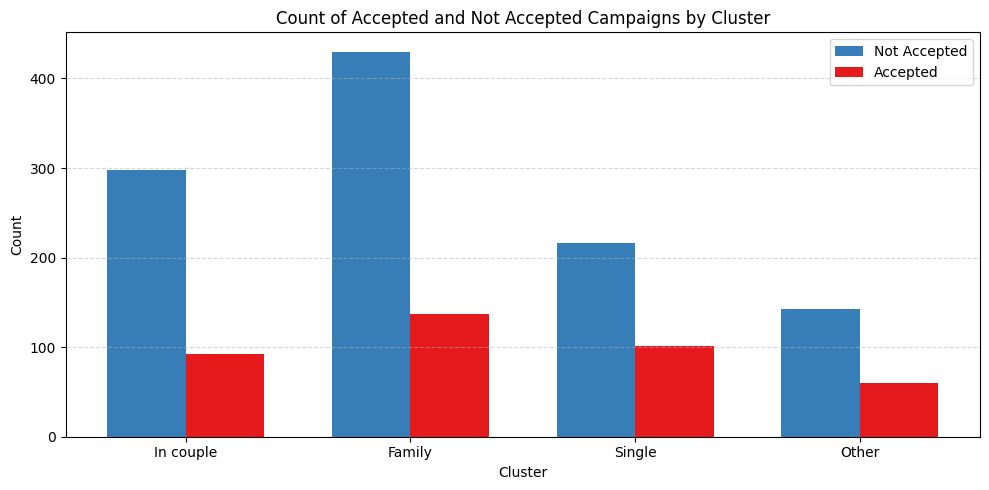

In [48]:
# Calculate the count of accepted and not accepted campaigns for each cluster
accepted_counts = []
not_accepted_counts = []

for cluster in range(best_k_mm):
    accepted_counts.append(np.sum(best_km_mm.labels_ == cluster) - np.sum(label_df.loc[best_km_mm.labels_ == cluster, 'Campaigns_Accepted']))
    not_accepted_counts.append(np.sum(label_df.loc[best_km_mm.labels_ == cluster, 'Campaigns_Accepted']))

# Create bar chart with side-by-side bars
plt.figure(figsize=(10, 5))
bar_width = 0.35
index = np.arange(best_k_mm)

bar1 = plt.bar(index - bar_width/2, accepted_counts, bar_width, label='Not Accepted', color=set1[1])
bar2 = plt.bar(index + bar_width/2, not_accepted_counts, bar_width, label='Accepted', color=set1[0])

plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Count of Accepted and Not Accepted Campaigns by Cluster')
plt.xticks(index, cluster_names_mm)
plt.legend()

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In this case, we do not have clear results. There are not really noticeable characteristic of any cluster, we can only notice that families accept more campaigns, but, as expected, this scaling does not provide any information about accepted or not accepted campaigns.